## Procesado de las series temporales

### Importamos las librerías necesarias

In [1]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import HydroErr as he

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.arima import model
from statsmodels.tsa.api import SARIMAX


from pmdarima.arima import auto_arima, decompose
from pmdarima.model_selection import train_test_split

from hurst import compute_Hc

from mlflow.models.signature import infer_signature

import warnings
warnings.filterwarnings("ignore") #Do not show warnings

### Cargamos las series temporales y las procesamos

Se crean cuatro dataframes, uno con la serie orginal a intervalos diarios y tres nuevos dataframes con la serie de aportaciones diarias, mensuales y anuales. Se eliminan los NaN.

In [25]:
#Cambiar por la serie a procesar

#df = pd.read_csv('C:/Users/alexd/Desktop/TFM/2046-Diaria.csv') #Adaja
df = pd.read_csv('C:/Users/alexd/Desktop/TFM/8030-Diaria.csv') # Mijares


#Procesamiento

df = df.dropna() #Eliminamos los NaN

df["ds"] =  pd.to_datetime(df["ds"], format="%d/%m/%Y")
df.set_index(df['ds'], inplace=True)

#Serie diaria
df_d = df.resample('D', on='ds').sum()

#Serie mensual
df_m = df.copy()
df_m["y"] = (df_m["y"] * 3600*24)/1000000 #Mensual
df_m = df_m.resample('M', on='ds').sum()

#Serie anual
df_a = df.copy()
df_a["y"] = (df_a["y"] * 3600*24)/1000000 #Anual
df_a['water_year'] = df_a.ds.dt.year.where(df_a.ds.dt.month < 10, df_a.ds.dt.year + 1) #Definition of water year
df_a = df_a.groupby('water_year')[['y']].sum() #Agrupamos por año hidrológico

### ADF Test - Estacionalidad

In [3]:
#Test de estacionalidad

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Valores de la serie diaria

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.666789e+01
p-value                 1.553975e-29
# lags used             4.900000e+01
# observations          2.661300e+04
critical value (1%)    -3.430596e+00
critical value (5%)    -2.861649e+00
critical value (10%)   -2.566828e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


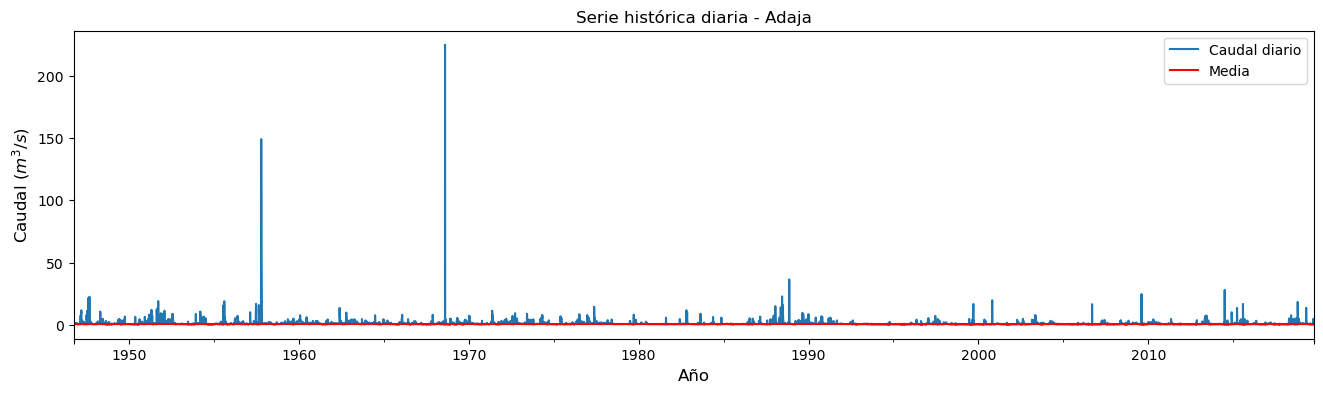

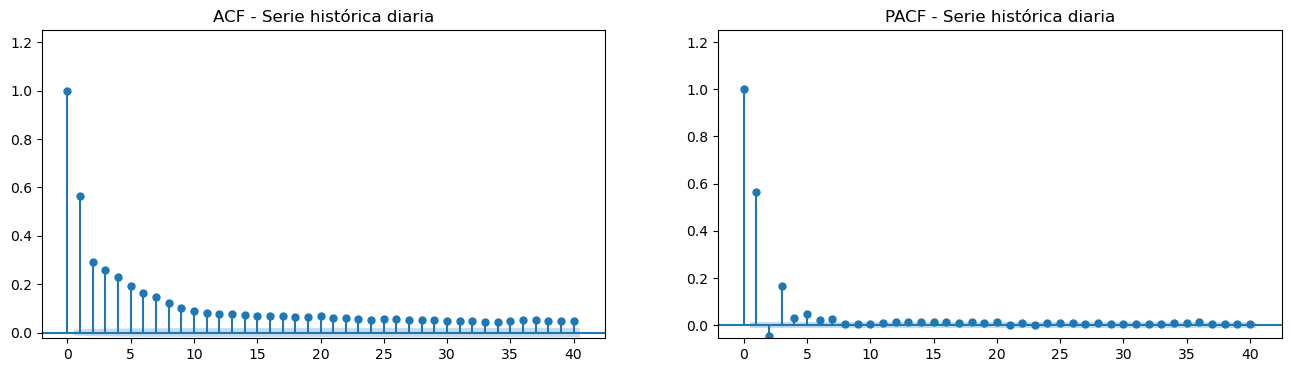

,y
nobs,2.666300e+04
missing,0.000000e+00
mean,8.366709e-01
std_err,8.584505e-05
upper_ci,8.368391e-01
lower_ci,8.365026e-01
std,2.288887e+00
iqr,5.100000e-01
iqr_normal,3.780636e-01
mad,6.134398e-01


In [98]:
#Procesamiento de la serie histórica diaria

#ADF test estacionalidad
adf_test(df_d['y'])

#Gráfica de la serie histórica
title='Serie histórica diaria - Adaja'
df_d.plot(title=title,figsize=(16, 4))
plt.axhline(y=np.nanmean(df_d.y),color="red",)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Caudal ($m^3/s$)', fontsize=12)
plt.legend(['Caudal diario','Media'])

#Autocorrelograma
acf(df_d['y'])

#PACF
pacf(df_d['y'],alpha=.05)

lags = 40

#Gráficas conjuntas
fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(df_d,title='ACF - Serie histórica diaria',lags=lags, auto_ylims=True, ax=ax[0])
plot_pacf(df_d,title='PACF - Serie histórica diaria',lags=lags, auto_ylims=True, ax=ax[1])
plt.show()



#Estadísticas de la serie temporal
describe(df_d) 

In [86]:
#Hurst
H, c, val = compute_Hc(df_d['y'])
print("Hurst exponent = {:.4f}".format(H))

Hurst exponent = 0.3994


### Valores de la serie mensual

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.052808e+00
p-value                 4.789065e-15
# lags used             4.000000e+00
# observations          8.710000e+02
critical value (1%)    -3.437880e+00
critical value (5%)    -2.864864e+00
critical value (10%)   -2.568540e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


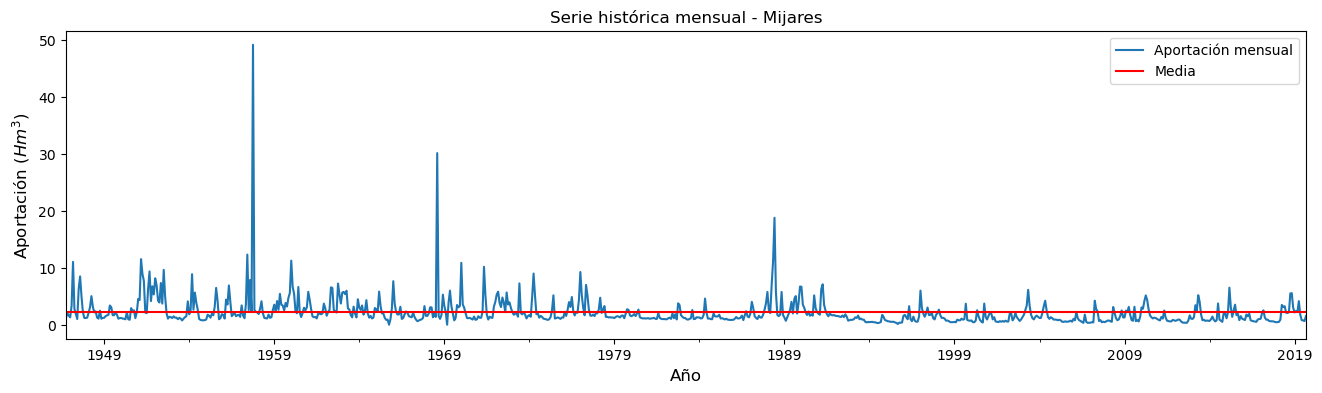

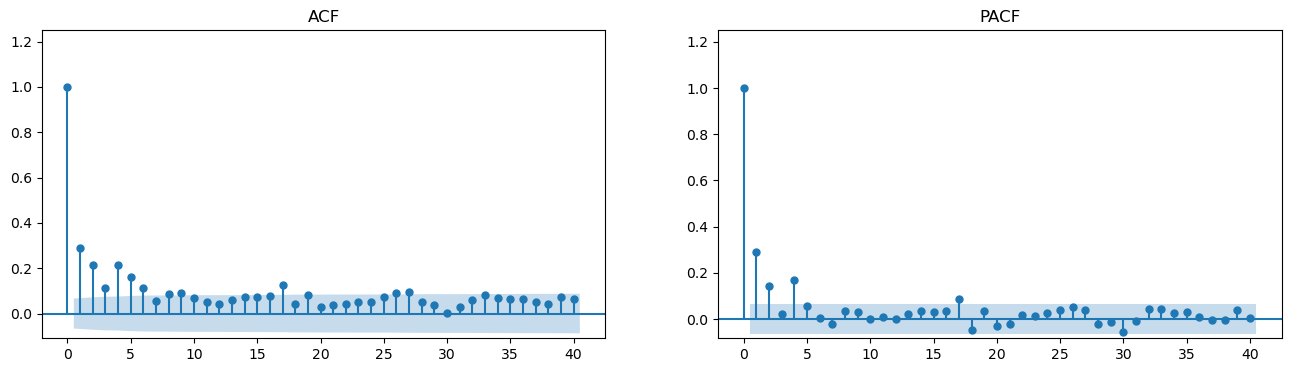

,y
nobs,876.000000
missing,0.000000
mean,2.200256
std_err,0.003012
upper_ci,2.206160
lower_ci,2.194353
std,2.638448
iqr,1.577664
iqr_normal,1.169524
mad,1.395019


In [13]:
#Procesamiento de la serie histórica mensual

#Gráfica de la serie histórica

title='Serie histórica mensual - Mijares'
df_m.plot(title=title,figsize=(16, 4))
plt.axhline(y=np.nanmean(df_m.y), color='red')

plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación mensual','Media'])

#Autocorrelograma
acf(df_m['y'],alpha=.05)
title = 'ACF'
lags = 40
#plot_acf(df_m,title=title,lags=lags, auto_ylims=True);

#PACF
pacf(df_m['y'],alpha=.05)
#plot_pacf(df_m,title='PACF - Serie histórica mensual',lags=lags, auto_ylims=True)

#ADF test estacionalidad
adf_test(df_m['y'])

#Gráficas conjuntas
fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(df_m,title=title,lags=lags, auto_ylims=True, ax=ax[0])
plot_pacf(df_m,title='PACF',lags=lags, auto_ylims=True, ax=ax[1])
plt.show()

#Estadísticas de la serie temporal
describe(df_m)


In [99]:
#Hurst
H, c, val = compute_Hc(df_m['y'], simplified=False)
print("Hurst exponent = {:.4f}".format(H))

Hurst exponent = 0.3972


### Valores de la serie anual


Augmented Dickey-Fuller Test: 
ADF test statistic      -5.208607
p-value                  0.000008
# lags used              1.000000
# observations          75.000000
critical value (1%)     -3.520713
critical value (5%)     -2.900925
critical value (10%)    -2.587781
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


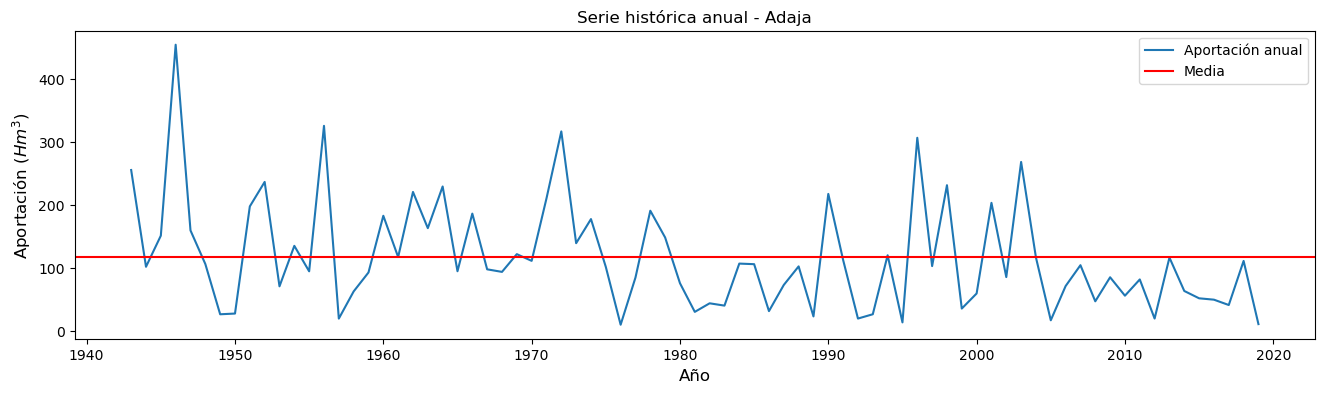

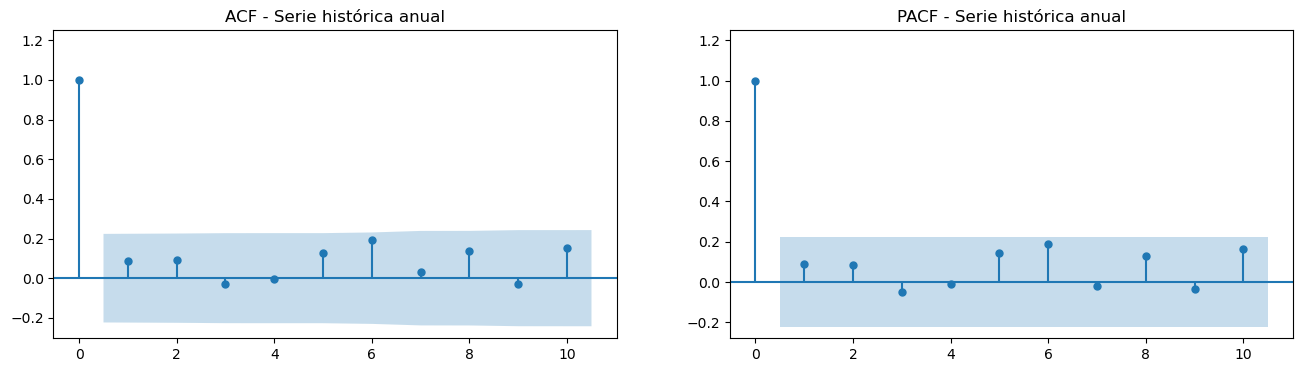

,y
nobs,7.700000e+01
missing,0.000000e+00
mean,1.167845e+02
std_err,1.125560e+00
upper_ci,1.189906e+02
lower_ci,1.145785e+02
std,8.666808e+01
iqr,1.078199e+02
iqr_normal,7.992698e+01
mad,6.531114e+01


In [16]:

#Procesamiento de la serie histórica anual

#Gráfica de la serie histórica
title='Serie histórica anual - Adaja'
df_a.plot(title=title,figsize=(16, 4))
plt.axhline(y=np.nanmean(df_a.y),color="red",)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','Media'])

#Autocorrelograma
acf(df_a['y'],alpha=.05)
title = 'ACF - Serie histórica anual'
lags = 10
#plot_acf(df_a,title='ACF - Serie histórica anual',lags=lags, auto_ylims=True);

#PACF
pacf(df_a['y'],alpha=.05)
#plot_pacf(df_a,title='PACF - Serie histórica anual',lags=lags, auto_ylims=True)

#ADF test estacionalidad
adf_test(df_a['y'])

#Gráficas conjuntas
fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(df_a,title=title,lags=lags, auto_ylims=True, ax=ax[0])
plot_pacf(df_a,title='PACF - Serie histórica anual',lags=lags, auto_ylims=True, ax=ax[1])
plt.show()

#Estadísticas de la serie temporal
describe(df_a)

In [7]:
serie = df_a
df1 = serie
df2 = serie
frames = [df1, df2]
df3 = pd.concat(frames)

#Hurst
H, c, val = compute_Hc(df3['y'], simplified=False)
print("Hurst exponent = {:.4f}".format(H))

Hurst exponent = 0.2382


### Guardado de las serie procesadas a Excel

In [7]:
#Mijares
#df_a.to_excel(r'C:/Users/alexd/Desktop/TFM/8030-Anual.xlsx', index=True)
df_a.to_excel(r'C:/Users/alexd/Desktop/TFM/8030-Anual.xlsx', index=True)

In [4]:
#Adaja
#df_a.to_excel(r'C:/Users/alexd/Desktop/TFM/2046-Anual.xlsx', index=True)
df_m.to_excel(r'C:/Users/alexd/Desktop/TFM/2046-Mensual.xlsx', index=True)

## Procesado de modelos ARIMA

### Dividimos el set de datos para entrenar el modelo
Se define el ajuste del modelo de manera automática.

In [22]:
#Ejecutar antes por consola mlflow ui
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ARIMA")

<Experiment: artifact_location='mlflow-artifacts:/865591528692790995', creation_time=1676806914145, experiment_id='865591528692790995', last_update_time=1676806914145, lifecycle_stage='active', name='ARIMA', tags={}>

### Realizamos una predicción para el set de test
Obtenemos también los intervalos de confianza.

In [26]:
test_size = 0.3 # Cambiar la amplitud de set de datos para el TEST

train , test = train_test_split(df_m, test_size = test_size) #Dividmos el set de datos para entrenar el modelo

print(f"Number of obs. in train data: {len(train)}")
print(f"Number of obs. in test data: {len(test)}")

Number of obs. in train data: 613
Number of obs. in test data: 263


In [27]:

arima_model = auto_arima(train, trace = True, seasonal = False, information_criterion = 'aic', test = 'adf', m=1)
prediction, confint = arima_model.predict(len(test), return_conf_int=True)
cf = pd.DataFrame(confint)
    
prediction_series = pd.Series(prediction,index=test.index)
train_series = pd.Series(arima_model.predict_in_sample(),index=train.index)
    
signature = infer_signature(train, prediction)
    
test_set = pd.concat([df_m, prediction_series], axis=1)
test_set = test_set.dropna()
    
RMSE = he.rmse(test_set[0], test_set['y'])
MAE = he.mae(test_set[0], test_set['y'])
NSE = he.nse(test_set[0], test_set['y'])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3420.413, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3194.096, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3291.753, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3137.812, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3127.609, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3087.622, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3079.361, Time=0.16 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3042.073, Time=0.90 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3052.759, Time=0.64 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3054.438, Time=0.77 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3040.071, Time=0.71 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3038.340, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3

In [ ]:
arima_model.summary()

### Coeficientes

In [15]:
print('El valor de MAE obtenido es: '+str(MAE))
print('El valor de RMSE obtenido es: '+str(RMSE))
print('El valor de NSE obtenido es: '+str(NSE))

El valor de MAE obtenido es: 13.623234273528395
El valor de RMSE obtenido es: 15.209228978585152
El valor de NSE obtenido es: -4.017296467722657


## Gráfico

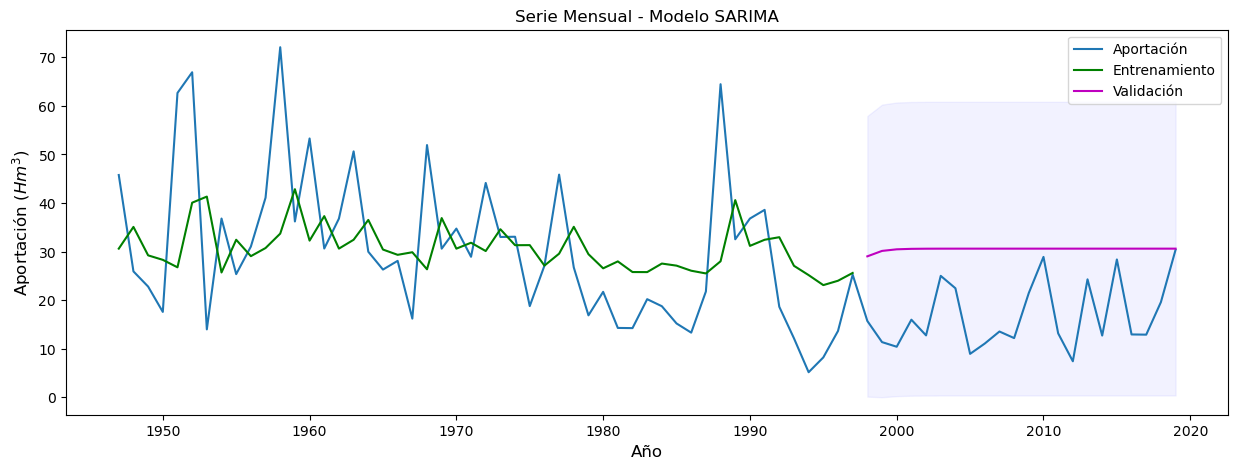

In [13]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df_a['y'])
ax.plot(train_series, color = 'green')
ax.plot(prediction_series, color = 'm')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='blue',alpha=.05)

plt.title('Serie Mensual - Modelo SARIMA')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación','Entrenamiento', 'Validación'])

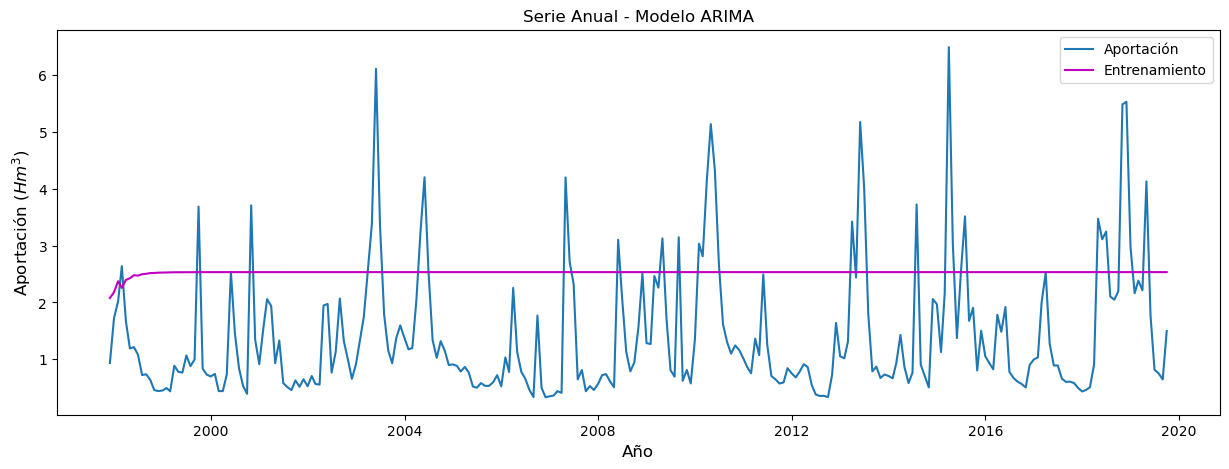

In [10]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df_m['y'].iloc[-len(test):])

ax.plot(prediction_series, color = 'm')

plt.title('Serie Anual - Modelo ARIMA')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación','Entrenamiento', 'Validación'])

### Exportación de resultados

In [44]:
#Guardamos los resultados del modelo ARIMA

model_results = pd.concat([df_a, prediction_series, train_series], axis=1)
model_results.rename(columns = {0:'Test', 1:'Train'}, inplace = True)
model_results

#Adaja
#model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados2046_ARIMA_Anual.xlsx', index=True)

#Mijares
#model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados8030_ARIMA_Anual.xlsx', index=True)

,y,Test,Train
water_year,,,
1943,255.495082,NaN,125.6148
1944,101.797430,NaN,125.6148
1945,151.222205,NaN,125.6148
1946,454.513248,NaN,125.6148
1947,159.526109,NaN,125.6148
...,...,...,...
2015,51.706253,125.6148,NaN
2016,49.547808,125.6148,NaN
2017,41.053824,125.6148,NaN


## Ajuste manual de modelo ARIMA

In [26]:
%%time
#Ajuste manual de modelo ARIMA

p,d,q = (5,0,0) #Cambiar por el deseado

with mlflow.start_run():


    arima = model.ARIMA(df_m['y'],order=(p,d,q))
    arima_model=arima.fit()

    forecast = arima_model.get_forecast(steps=len(test))
    prediction = forecast.predicted_mean

    confint = forecast.conf_int(alpha=0.05)
    cf = pd.DataFrame(confint)


    prediction_series = pd.Series(pd.Series(prediction.to_numpy(),index=test.index),index=test.index)
    train_series = pd.Series(arima_model.get_prediction(end=len(train)-1).predicted_mean.to_numpy(),index=train.index)

    signature = infer_signature(train, prediction)

    test_set = pd.concat([df_m, prediction_series], axis=1)
    test_set = test_set.dropna()

    RMSE = he.rmse(test_set[0], test_set['y'])
    MAE = he.mae(test_set[0], test_set['y'])
    NSE = he.nse(test_set[0], test_set['y'])

    mlflow.pmdarima.log_model(arima_model, registered_model_name = 'MIJARES-Mensual', artifact_path = 'arima-model') # Cambiar el nombre del modelo
        
    mlflow.log_param('p', p)
    mlflow.log_param('d', d)
    mlflow.log_param('q', q)
    
    mlflow.log_metric('RMSE', RMSE)
    mlflow.log_metric('MAE', MAE)
    mlflow.log_metric('NSE', NSE)
    mlflow.log_metric('Test_size', test_size)

Registered model 'MIJARES-Mensual' already exists. Creating a new version of this model...
2023/03/26 11:45:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: MIJARES-Mensual, version 5
Created version '5' of model 'MIJARES-Mensual'.


CPU times: total: 516 ms
Wall time: 9.12 s


In [21]:
#Coeficientes de ajuste
print('El valor de MAE obtenido es: '+str(MAE))
print('El valor de RMSE obtenido es: '+str(RMSE))
print('El valor de NSE obtenido es: '+str(NSE))

El valor de MAE obtenido es: 1.2152852027956835
El valor de RMSE obtenido es: 1.365704132369839
El valor de NSE obtenido es: -0.4832335508244179


In [29]:
#Predicción anual ARIMA
p,d,q = (5,0,0) #Cambiar por el deseado


arima = model.ARIMA(df_m['y'],order=(p,d,q))
arima_model=arima.fit()

forecast = arima_model.get_forecast(steps=24)
forecast.predicted_mean

2019-10-31    1.656637
2019-11-30    1.729622
2019-12-31    1.721579
2020-01-31    1.849204
2020-02-29    1.949637
2020-03-31    2.008181
2020-04-30    2.032858
2020-05-31    2.061802
2020-06-30    2.092624
2020-07-31    2.117257
2020-08-31    2.132920
2020-09-30    2.144440
2020-10-31    2.154671
2020-11-30    2.163522
2020-12-31    2.170278
2021-01-31    2.175266
2021-02-28    2.179204
2021-03-31    2.182463
2021-04-30    2.185090
2021-05-31    2.187127
2021-06-30    2.188708
2021-07-31    2.189968
2021-08-31    2.190981
2021-09-30    2.191783
Freq: M, Name: predicted_mean, dtype: float64

## Ajuste de modelo SARIMA

In [22]:
%%time
#Ajuste manual de modelo SARIMA

p,d,q = (1,0,3) #Cambiar por el deseado
P,D,Q,s = (0,0,1,4)

with mlflow.start_run():

    arima = SARIMAX(endog=df_m['y'],order=(p,d,q),seasonal_order=(P,D,Q,s))
    arima_model=arima.fit()

    forecast = arima_model.get_forecast(steps=len(test))
    forecast.predicted_mean[forecast.predicted_mean.lt(0)] = 0 # Se eliminan los valores negativos predictivos
    prediction = forecast.predicted_mean
        

    confint = forecast.conf_int(alpha=0.05)
    cf = pd.DataFrame(confint)


    prediction_series = pd.Series(pd.Series(prediction.to_numpy(),index=test.index),index=test.index)
    train_series = pd.Series(arima_model.get_prediction(end=len(train)-1).predicted_mean.to_numpy(),index=train.index)

    signature = infer_signature(train, prediction)

    test_set = pd.concat([df_m, prediction_series], axis=1)
    test_set = test_set.dropna()

    RMSE = he.rmse(test_set[0], test_set['y'])
    MAE = he.mae(test_set[0], test_set['y'])
    NSE = he.nse(test_set[0], test_set['y'])

    mlflow.pmdarima.log_model(arima_model, registered_model_name = 'MIJARES-Mensual', artifact_path = 'sarima-model') # Cambiar el nombre del modelo
        
    mlflow.log_param('p', p)
    mlflow.log_param('d', d)
    mlflow.log_param('q', q)
    mlflow.log_param('P1', P)
    mlflow.log_param('D1', D)
    mlflow.log_param('Q1', Q)
    mlflow.log_param('s', s)
    
    mlflow.log_metric('RMSE', RMSE)
    mlflow.log_metric('MAE', MAE)
    mlflow.log_metric('NSE', NSE)
    mlflow.log_metric('Test_size', test_size)

Successfully registered model 'MIJARES-Mensual'.
2023/03/25 21:42:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: MIJARES-Mensual, version 1
Created version '1' of model 'MIJARES-Mensual'.


CPU times: total: 1.31 s
Wall time: 11.6 s


In [23]:
#Coeficientes de ajuste
print('El valor de MAE obtenido es: '+str(MAE))
print('El valor de RMSE obtenido es: '+str(RMSE))
print('El valor de NSE obtenido es: '+str(NSE))

El valor de MAE obtenido es: 0.9698067092186164
El valor de RMSE obtenido es: 1.2950659737291177
El valor de NSE obtenido es: 0.001578883022742783


In [54]:
# Predicción mensual SARIMA
p,d,q = (2,0,2) #Cambiar por el deseado
P,D,Q,s = (1,0,1,6)

arima = SARIMAX(endog=df_m['y'],order=(p,d,q),seasonal_order=(P,D,Q,s))
arima_model=arima.fit()

forecast = arima_model.get_forecast(steps=24)
forecast.predicted_mean[forecast.predicted_mean.lt(0)] = 0 # Se eliminan los valores negativos predictivos
forecast.predicted_mean


## Gráfico

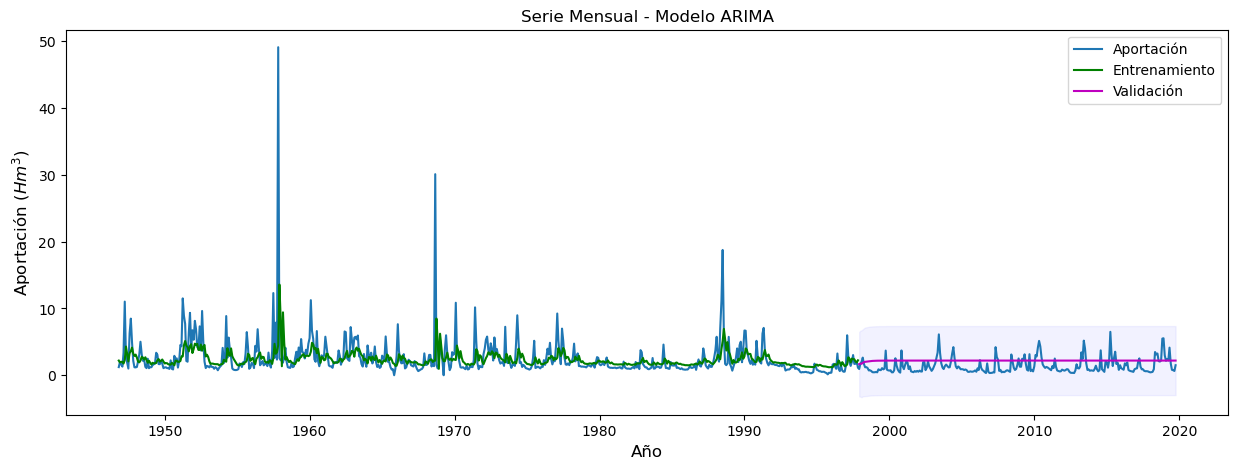

In [27]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df_m['y'])
ax.plot(train_series, color = 'green')
ax.plot(prediction_series, color = 'm')
ax.fill_between(prediction_series.index,
                cf['lower y'],
                cf['upper y'],color='blue',alpha=.05)

plt.title('Serie Mensual - Modelo ARIMA')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación','Entrenamiento', 'Validación'])

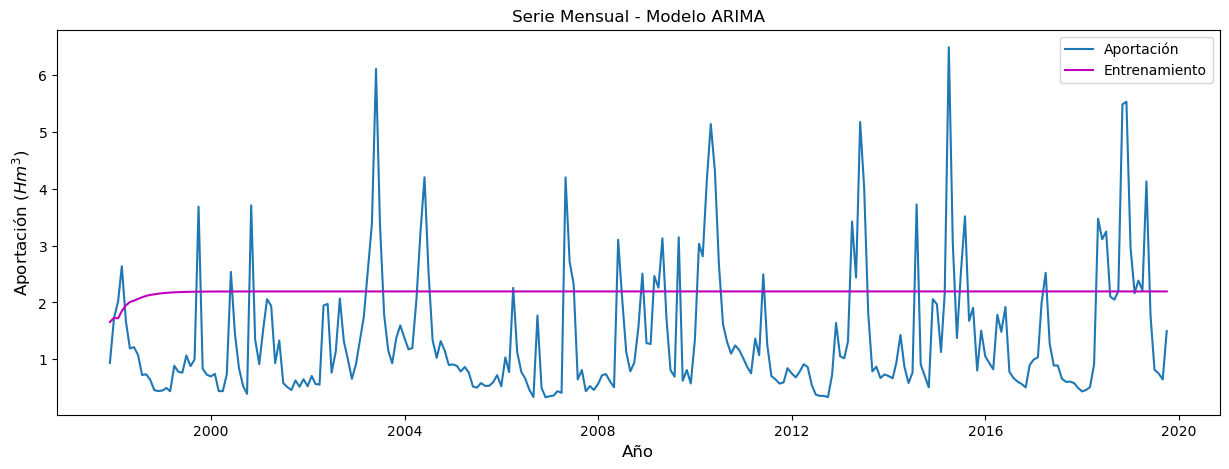

In [28]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(df_m['y'].iloc[-len(test):])

ax.plot(prediction_series, color = 'm')

plt.title('Serie Mensual - Modelo ARIMA')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación','Entrenamiento', 'Validación'])